# Лабораторная работа по теории управления №2
### Выполнили: Репин В., Вихрев И., Перов Д.

In [211]:
import sympy 
import numpy as np
import matplotlib.patches as pts
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from sympy import re,im
from sympy.matrices import *
from sympy.parsing.sympy_parser import parse_expr
from sympy.utilities.lambdify import lambdify
from scipy.integrate import solve_ivp
plt.rcParams["animation.html"] = 'html5'
plt.rcParams['animation.ffmpeg_path'] = 'D:\\Soft\\Anaconda\\Library\\bin\\ffmpeg.exe'
plt.style.use('seaborn-paper')

In [212]:
# Построение фазового портрета (только для двухмерной системы)
def phaseport(syst, nsyst, eq_info):
    xst = [] # Точки с.р. на оси x
    for i in range(0,len(eq_info)):
        xst.append(np.float64(eq_info[i][0][0]))
    rg = abs(max(xst,key=abs)) # Выбираем максимум по модулю чтобы охватить на фазовом портрете все с.р.
    
    # Построение Ф.П.
    x, y = np.linspace(-rg-0.1, rg+0.1, 50), np.linspace(-rg-0.1, rg+0.1, 50)
    X, Y = np.meshgrid(x, y)
    U, V = nsyst(0, [X, Y])
    plt.streamplot(X, Y, U, V)
    
    # Добавление точек с.р.
    plt.plot(xst, np.zeros(len(xst)), 'ro')
    # Добавление изоклины Г oo
    plt.plot([-rg-0.1,rg+0.1], [0,0], linewidth=1.0, color='blue')
    # Добавление изоклины Г 0
#     func = sympy.solve(syst[1],parse_expr('f1'))
#     if(len(func) != 0):
#         isocline = lambdify(parse_expr('f0'),sympy.solve(syst[1],parse_expr('f1'))[0], modules=['numpy'])
#         plt.plot(x, isocline(x), linewidth=1.0, color='blue')
#     else:
#         plt.plot([0,0], [-rg-0.1,rg+0.1], linewidth=1.0, color='blue')
#     # Добавление собственных векторов с.р. 
    for eq in eq_info:
        if (eq[1] == 'Седло'):
            plt.plot([eq[0][0]+eq[2][0][0],eq[0][0]-eq[2][0][0]],
                     [eq[0][1]+eq[2][0][1],eq[0][1]-eq[2][0][1]],linewidth=1.0, color="red")            
            plt.plot([eq[0][0]+eq[2][1][0],eq[0][0]-eq[2][1][0]],
                     [eq[0][1]+eq[2][1][1],eq[0][1]-eq[2][1][1]],linewidth=1.0, color='red')
            
    plt.ylim((-rg-0.1,rg+0.1))
    plt.xlim((-rg-0.1,rg+0.1))
    plt.show()

In [213]:
# Информация о состояниях равновесия и выбранном управлении (для двухмерной определяется тип)
def eqstate_info(syst, svars):
    # Символьный поиск с.р. (если нельзя получить символьно, решается численно)
    try:
        _,eqstates = sympy.solve(syst,svars,set=True)
        eqstates_fix = set()
        for state in eqstates:
            if(len(state) == 3):
                state = (state[0],state[1],svars[2],state[2])
            eqstates_fix.add(state) 
        eqstates = eqstates_fix
    except:
        if(len(syst) == 4):
            svars_fix =[svars[0],svars[1],svars[3]]
            sol1 = sympy.nsolve(syst,svars_fix,[0,0,0], set = True)
            try:
                sol2 = sympy.nsolve(syst,svars_fix,[np.pi,0,0], set = True)
                eqstates = {(sol1[0],sol1[1],svars[2],sol1[2]),(sol2[0],sol2[1],svars[2],sol2[2])}
            except:
                eqstates = {(sol1[0],sol1[1],svars[2],sol1[2])}
        else:
            sol1 = sympy.nsolve(syst,svars,[0,0], set = True)
            sol2 = sympy.nsolve(syst,svars,[np.pi,0], set = True)
            eqstates = {(sol1[0],sol1[1]),(sol2[0],sol2[1])}
        
    nonlinear = Matrix(syst)
    result = []
    verdict = True
    # Для каждого с.р. получаем список собственных чисел, исследуем на устойчивость
    for state in eqstates:   
        if(state[0]!= 0 and state[0] < 1e-16):
            continue
        state_sub = list(zip(svars,state))
        eigen = nonlinear.jacobian(svars).subs(state_sub).eigenvects() 
        lambdas = []
        vects = []
        for lamstr in eigen:
            vects.extend(lamstr[2])
            for i in range(lamstr[1]):
                lambdas.append(lamstr[0])
        stability = 'Асимптотически устойчивое'
        zeros = 0
        imag = 0
        for lam in lambdas:
            if(re(lam) > 0):
                stability = 'Неустойчивое'
            elif(re(lam) == 0):
                if(im(lam) == 0):
                    zeros+=1
                else:
                    imag+=1
        if(imag+zeros == len(syst) and imag == 2):
            stability = 'Устойчивое(гарм. колебания)'
        # Проверяем, что с.р. верные
        if((state == (0,0) or state == (0,0,parse_expr('x0'),0)) and stability == 'Неустойчивое'):
            verdict = False
        if(state != (0,0) and state != (0,0,parse_expr('x0'),0) and (stability == 'Асимптотически устойчивое' 
                                                                     or stability == 'Устойчивое(гарм. колебания)')):
            verdict = False
                
        # Узнаём тип для сист. второго порядка
        if(len(syst) == 2):
            if(im(lambdas[0]) == 0.0):
                if(lambdas[0]*lambdas[1] < 0):
                    stype = 'Седло'
                elif (lambdas[0] < 0 and lambdas[1] < 0):
                    stype = 'Уст. узел'
                elif (lambdas[0] > 0 and lambdas[1] > 0): 
                    stype = 'Неуст. узел'
                else:
                    stype = 'Сложное с.р.'
            elif(re(lambdas[0]) < 0):
                stype = 'Уст. фокус'
            elif(re(lambdas[0]) > 0):
                stype = 'Неуст. фокус'
            else:
                stype = 'Центр(в лин.)' 
            stability = stype
        result.append([state,stability,vects]) # (Сост.Равн., Тип/устойчивость, Собств.Вект.)
    return verdict,result             

In [214]:
# Построение осцилограмм и анимации
def int_curve(nsyst,x:np.array,t,h):
    # Численное интегрирование 
    time_span = np.arange(0, t, h)
    data = solve_ivp(nsyst, (time_span[0], time_span[-1]), x, t_eval=time_span)
    #Построение осцилограмм
    for i in range (len(x)):
        plt.plot(time_span,data.y[i])
    plt.legend([r'$\phi$', r'$\dot{\phi}$',r'$x$',r'$\dot{x}$'], fontsize=10)
    plt.xlabel('t', fontsize=10)
    plt.show() 
    
    
    fig = plt.figure()
    ax = plt.gca()
    ax.grid(True, which='both')
    ax.axhline(y=0, color='k', linestyle = '--')
    ax.axvline(x=0, color='k', linestyle = '--')
    ax.axis('equal')
    ln, = plt.plot([], [], 'r', animated=True)
    cr = ax.add_patch(plt.Circle((0,0),0.05,color='red'))
    if(len(x) == 2):
        def init():
            ax.set_xlim(-2, 2)
            ax.set_ylim(-1.5, 1.5)
            return []
        def update(frame):
            patches = []
            ln.set_data([0,np.cos(np.pi/2+data.y[0][frame])], [0,np.sin(np.pi/2+data.y[0][frame])])
            cr.set_center((np.cos(np.pi/2+data.y[0][frame]),np.sin(np.pi/2+data.y[0][frame])))
            patches = [ln,cr]
            return patches
    else:
        def init():
            ax.set_xlim(-2, 2)
            ax.set_ylim(-1.5, 1.5)
            return []
        def update(frame):
            ax.set_xlim(data.y[2][frame]-2, data.y[2][frame]+2)
            ax.set_ylim(-1.5, 1.5)
            patches = []
            ln.set_data([data.y[2][frame],data.y[2][frame]+np.cos(np.pi/2+data.y[0][frame])], 
                        [0,np.sin(np.pi/2+data.y[0][frame])])
            cr.set_center((data.y[2][frame]+np.cos(np.pi/2+data.y[0][frame]),
                           np.sin(np.pi/2+data.y[0][frame])))
            patches = [ln,cr]
            return patches
    ani = animation.FuncAnimation(fig, update, frames=len(time_span),
                    init_func=init, blit=True, interval = 10,repeat=True)
    plt.close()
    return ani.to_html5_video(),data.y

In [218]:
# Полное исследование при заданном управлении и параметрах
def full_research(system, svars, u, params, probes, time, step):
    # Подстановка управления и параметров в символьную систему
    syst = []
    for val in system:
        syst.append(val.subs(parse_expr('u'),u).subs(params))

    # Получение информации об управлении, состояниях равновесия и её вывод   
    verdict,eq_info = eqstate_info(syst, svars)  
    print("Управление верно:", verdict)
    print('--------------------------------------------------------------------')
    print("Состояния равновесия:")
    for i in range(0,len(eq_info)):
        print(eq_info[i][1]," в ", eq_info[i][0])
        
    # Генерация функции системы от состояния для численного интегрирования и фазового портрета
    nsyst_no_t = lambdify([svars],syst,modules = ['numpy'])
    def nsyst(t,x:np.array):
        return nsyst_no_t(x)
    
    # Для системы второго порядка построение фазового портрета
    if(len(system) == 2):
        print('--------------------------------------------------------------------')
        print("Фазовый портрет системы:")
        phaseport(syst,nsyst,eq_info)
        
        
    print('--------------------------------------------------------------------')    
    print("Осцилограммы и соответствующие анимации:")
    for probe in probes:
        vid,_ = int_curve(nsyst,probe,time,step)
        display(HTML(vid))
        print('--------------------------------------------------------------------')

#  1. Стабилизация математического маятника в вертикальном положении вращением в точке крепления
## 1.1 Вывод уравнения математического маятника с управлением вращением
  

### Способ 1: Уравнения Лагранжа 2-го рода

\begin{align}
&К = \frac{m}{2} (\dot{x}^2 + \dot{y}^2) \\
&П = mlg\cos{\phi} \\
&L = К - П = \frac{m}{2} (l^2 \dot{\phi}^2 - 2lg\cos{\phi})\\
&\frac{\partial L}{\partial \phi} = mlg\sin{\phi} \\
&\frac{\partial L}{\partial \dot{\phi}} = ml^2\dot{\phi} \\
&\frac{d}{dt}(\frac{\partial L}{\partial \dot{\phi}}) = ml^2\ddot{\phi} \\
&\frac{d}{dt}(\frac{\partial L}{\partial \dot{\phi}}) - \frac{\partial L}{\partial \phi} = \widetilde{u}(\phi,\dot{\phi},t) - \widetilde{k}\dot{\phi} \\
&ml^2\ddot{\phi} - mlg\sin{\phi} = \widetilde{u}(\phi,\dot{\phi},t) - \widetilde{k}\dot{\phi} | : ml^2 \\
&\ddot{\phi} + \frac{\widetilde{k}\dot{\phi}}{ml^2} - \frac{g}{l}\sin{\phi} = \frac{\widetilde{u}(\phi,\dot{\phi},t)}{ml^2} \\
&Сделаем \: замену: \\
&\frac{\widetilde{k}}{ml^2} = 2k ;\: \frac{g}{l} = \omega^2 ;\: \frac{\widetilde{u}(\phi,\dot{\phi},t)}{ml^2} = u(\phi,\dot{\phi},t) \\
&Результат: \\
&\ddot{\phi} + 2k\dot{\phi} - \omega^2\sin{\phi} = u(\phi,\dot{\phi},t) \\
&k - коэффициент \: затухания \\
&\omega - собственная \: частота \: маятника \\
&u - управление \\
\end{align}

### Способ 2: Закон Ньютона для вращательного движения

\begin{align}
&\ddot{\phi} = \frac{\sum{M}}{J} = \frac{M_{F_{тр}} + M_{F_т} + M_u}{J} \\
&\ddot{\phi} = \frac{-\widetilde{k}\dot{\phi} + mgl\sin{}\phi + \widetilde{u}(\phi,\dot{\phi},t)}{ml^2} \\
&После \: аналогичных \: замен \: и \: переноса: \\
&\ddot{\phi} + 2k\dot{\phi} - \omega^2\sin{\phi} = u(\phi,\dot{\phi},t) \\
&k - коэффициент \: затухания \\
&\omega - собственная \: частота \: маятника \\
&u - управление \\
\end{align}

## 1.2 Исследование системы без управления

In [216]:
spin_system = [parse_expr('f1'),parse_expr('-2*k*f1 + l*sin(f0)/9.81 + u')] # Разомкнутая система с параметрами
spinvars = [parse_expr('f0'),parse_expr('f1')] # Переменные системы
nocontrol = parse_expr('0') # Без управления
linear_control = parse_expr('a*f0') # Простое линейное управление
oscill_control = parse_expr('a*sin(f0)') # Простое осцилляторное управление

Управление верно: False
--------------------------------------------------------------------
Состояния равновесия:
Уст. фокус  в  (3.14159265358979, 0.0)
Седло  в  (0.0, 0.0)
--------------------------------------------------------------------
Фазовый портрет системы:


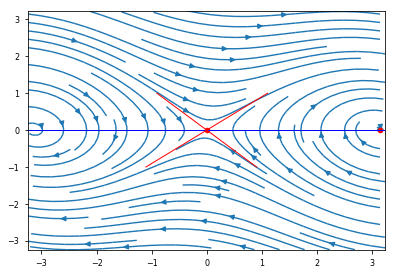

--------------------------------------------------------------------
Осцилограммы и соответствующие анимации:


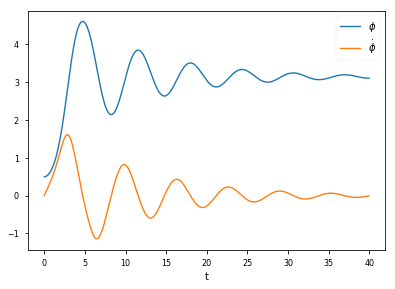

--------------------------------------------------------------------


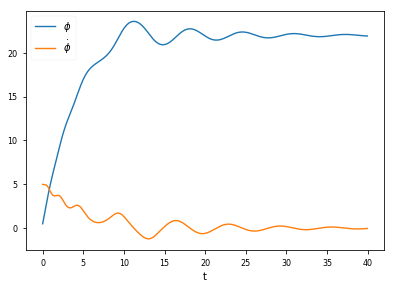

--------------------------------------------------------------------


In [219]:
full_research(spin_system,spinvars,nocontrol,[("k",0.1),("l",9.81)],[[0.5,0],[0.5,5]],40, 0.05)

Из представленных материалов исследования следует, что нужными нам свойствами система без управления не обладает, следующий этап работы - выбор класса функций для управления и подбор конкретного управления.

## 1.3 Выбор управления для стабилизации маятника в вертикальном состоянии
Для управления системой будет использоваться управление по состоянию, состоянием считаем $(\phi,\dot{\phi})$.
Для того чтобы выбрать управление, вначале необходимо поставить некоторые ограничения на тип функций, которые можно использовать. Условие можно получить из необходимости иметь с.р. в точке $(0,0)$ и иметь(неуст.) или не иметь в $(\pi,0)$:

\begin{align}
& В \: точке \: (0,0): \\
& -2k\phi +\omega^2\sin{\phi} + u(\phi,\dot{\phi}) = 0\\
& Следовательно: \\
& u(0,0) = 0
\end{align}

Достаточно легко подобрать такие функции, чтобы это условие выполнялось, например:

\begin{align}
& Простое \: линейное \: управление:  \\
& u = a\phi\\
& Простое \: осцилляторное \: управление: \\
& u = a\sin{\phi} \\
\end{align}

Причём для линейного в $(\pi,0)$ отсутствует с.р.

Второе условие - на устойчивость в точке $(0,0)$ и неустойчивость в $(\pi,0)$. С помощью него можно будет подобрать параметр $a$.:

\begin{align}
& \text{Характеристическое уравнение линеаризованной системы с простым линейным управлением:}  \\
&\begin{vmatrix}
  -\lambda & 1\\
  \omega^2 + a & -2k-\lambda
\end{vmatrix} = 0 \\
& Откуда: \\
& \lambda_{1,2} = -k \pm \sqrt{k^2 + \omega^2 + a} \\
& Условие \: устойчивости: \\
& a < -\omega^2 \\
& \text{Также можно добавить условие для избежания колебаний:} \\
& a > -k^2 -w^2\\
\end{align} 

Итак, для простого линейного управления оптимальное пространство для параметра a:  $(-k^2-\omega^2,\omega^2)$, или 
для уже выбранных параметров - $(-1.25,-1)$ (управление будет работать и для меньших a, но будут происходить затухающие колебания).
Проверим полученный результат, исследовав замкнутую систему:

Управление верно: True
--------------------------------------------------------------------
Состояния равновесия:
Уст. узел  в  (0, 0)
--------------------------------------------------------------------
Фазовый портрет системы:


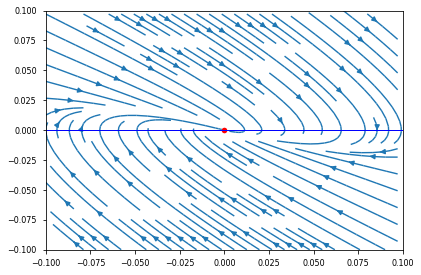

--------------------------------------------------------------------
Осцилограммы и соответствующие анимации:


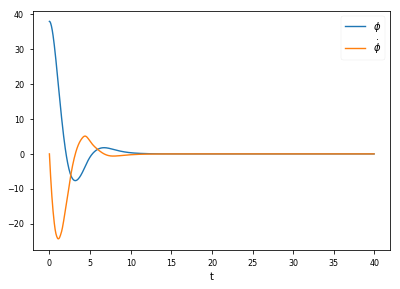

--------------------------------------------------------------------


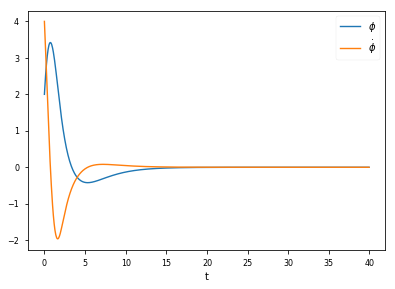

--------------------------------------------------------------------


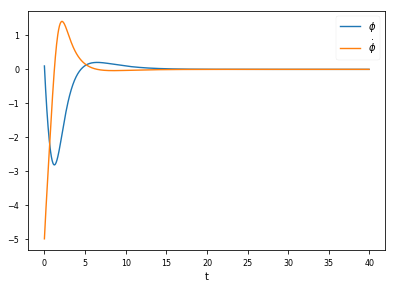

--------------------------------------------------------------------


In [220]:
full_research(spin_system,spinvars,linear_control,[("k",0.5),("l",9.81),("a",-1.24)],[[38,0],[2,4],[0.1,-5]],40, 0.05)

А также при меньших значениях a:

Управление верно: True
--------------------------------------------------------------------
Состояния равновесия:
Уст. фокус  в  (0, 0)
--------------------------------------------------------------------
Фазовый портрет системы:


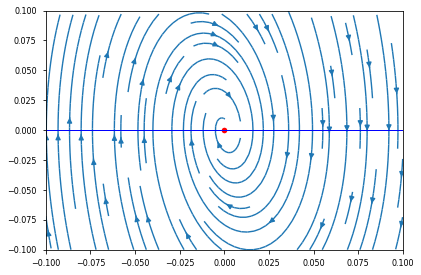

--------------------------------------------------------------------
Осцилограммы и соответствующие анимации:


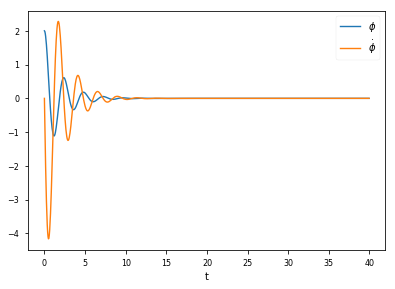

--------------------------------------------------------------------


In [221]:
full_research(spin_system,spinvars,linear_control,[("k",0.5),("l",9.81),("a",-8)],[[2,0]],40, 0.05)

Условия для параметра осцилляторного контроля аналогичны, в силу того что при $\phi = 0$, характеристические уравнения линеаризованных систем будут одинаковы, а условие неустойчивости с.р. при $\phi = \pi$ совпадает с условием устойчивости при $\phi = 0$. Проверим полученный результат, исследовав замкнутую систему:

Управление верно: True
--------------------------------------------------------------------
Состояния равновесия:
Седло  в  (3.14159265358979, 0.0)
Уст. узел  в  (0.0, 0.0)
--------------------------------------------------------------------
Фазовый портрет системы:


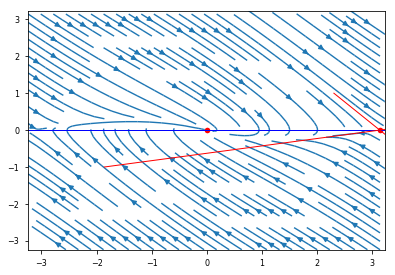

--------------------------------------------------------------------
Осцилограммы и соответствующие анимации:


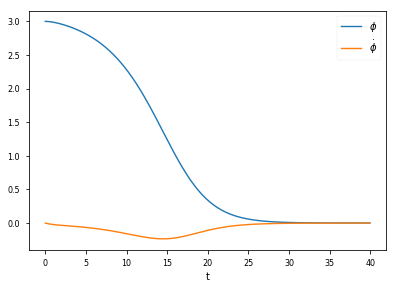

--------------------------------------------------------------------


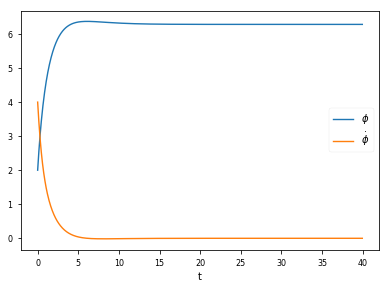

--------------------------------------------------------------------


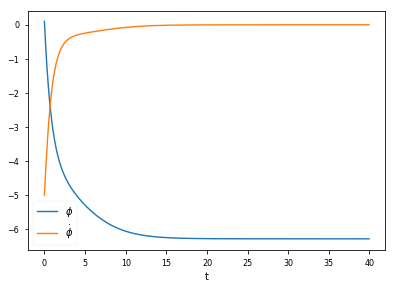

--------------------------------------------------------------------


In [225]:
full_research(spin_system,spinvars,oscill_control,[("k",0.5),("l",9.81),("a",-1.24)],[[3,0],[2,4],[0.1,-5]],40, 0.05)

А также при меньших значениях a:

Управление верно: True
--------------------------------------------------------------------
Состояния равновесия:
Седло  в  (3.14159265358979, 0.0)
Уст. фокус  в  (0.0, 0.0)
--------------------------------------------------------------------
Фазовый портрет системы:


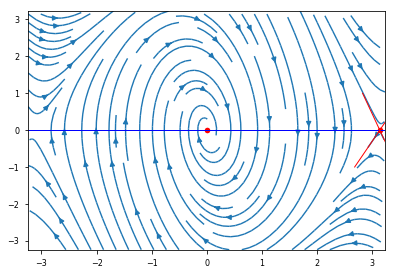

--------------------------------------------------------------------
Осцилограммы и соответствующие анимации:


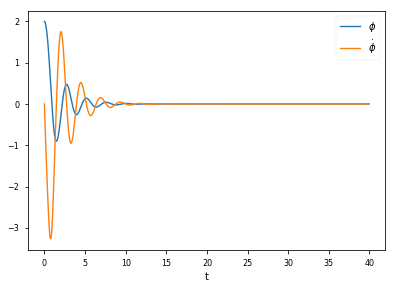

--------------------------------------------------------------------


In [226]:
full_research(spin_system,spinvars,oscill_control,[("k",0.5),("l",9.81),("a",-8)],[[2,0]],40, 0.05)

Итак, оба предложенных управления работают корректно, обеспечивая стабилизацию маятника в вертикальном положении.
При этом оба управления используют только текущий угол для работы, что упрощает реализацию. Можно обеспечивать стабилизацию в двух режимах: периодическом и апериодическом, при этом в необходимой позиции достигнута асимптотическая устройчивость. Осцилляторное управление отличается от линейного тем, что оставляет в качестве неустойчивого с.р. нижнее положение маятника.

# 2. Стабилизация математического маятника в вертикальном положении движением точки крепления
## 2.1 Вывод уравнения математического маятника с управлением движением

### Способ 1: Уравнения Лагранжа 2-го рода

\begin{align}
&К = \frac{Mv^2_{1}}{2} + \frac{mv^2_{2}}{2}  , v_{1} - \text{скорость тележки}, v_{2} - \text{скорость груза} \\
&П = mgl\cos{\phi} \\
&v^2_{1} = \dot{x}^2 \\
&v^2_{2} = (\frac{d}{dt}(x-l\sin{\phi}))^2 + (\frac{d}{dt}(l\cos{\phi}))^2 = \dot{x}^2 -2l\dot{x}\dot{\phi}\cos{\phi}+l^2\dot{\phi}^2 \\
&L = К - П = \frac{(M+m)\dot{x}^2}{2} - ml\dot{x}\dot{\phi}\cos{\phi} + \frac{ml^2\dot{\phi}^2}{2} - mlg\cos{\phi} \\
& \begin{cases}
    \frac{d}{dt}(\frac{\partial L}{\partial \dot{x}}) - \frac{\partial L}{\partial x} = u \\
    \frac{d}{dt}(\frac{\partial L}{\partial \dot{\phi}}) - \frac{\partial L}{\partial \phi} = 0
 \end{cases} \\
& \begin{cases}
    \ddot{x}(M+m) -\ddot{\phi}ml\cos{\phi} = u-ml^2\dot{\phi}^2\sin{\phi} \\
    \ddot{x}\cos{\phi} -\ddot{\phi}l = -g\sin{\phi}
 \end{cases} \\
&\text{СЛУ относительно } \ddot{x} \: и \: \ddot{\phi}, \text{применим метод Крамера:} \\
&\text{После решения и замены u:}\\
& \begin{cases}
    \ddot{x} = \frac{(g\cos{\phi} - l\dot{\phi}^2)\sin{\phi} + u}{\sin^2{\phi} + \frac{M}{m}} \\
    \ddot{\phi} = \frac{(g(M+m) - ml\dot{\phi}^2\cos{\phi})\sin{\phi} + u m \cos{\phi}}{(M+m\sin^2{\phi})l}
 \end{cases} \\
\end{align}

### Способ 2: Законы Ньютона

\begin{align}
& \begin{cases}
    F - R_{x} = M\ddot{x} \\
    F_{N} - R_{y} - Mg = 0 
 \end{cases} \\
& \vec{r} = (x - l\sin{\phi})\vec{i} + l\cos{\phi}\vec{j} \\
& \vec{a} = (\ddot{x} + l\dot{\phi}^2\sin{\phi} - l\ddot{\phi} \cos{\phi})\vec{i} + (-l\dot{\phi}^2 
\cos{\phi} - l\ddot{\phi}\sin{\phi})\vec{j} \\
& R_{x} = m(\ddot{x} + l\dot{\phi}^2\sin{\phi} - l\ddot{\phi} \cos{\phi}) \\
& R_{y} - mg = m(-l\dot{\phi}^2 \cos{\phi} - l\ddot{\phi}\sin{\phi}) \\
& \text{После подстановки получаем первое уравнение:} \\
& \ddot{x}(M+m) -\ddot{\phi}ml\cos{\phi} = u-ml^2\dot{\phi}^2\sin{\phi} \\
& \text{Далее введём вектор перпендикулярный маятнику:} \\
& \widetilde{x_{B}} = \cos{\phi}\vec{i} + sin {\phi} \vec{j} \\
& \text{Скалярно умножаем на уравнение движения маятника:} \\
& (\widetilde{x_{B}} , \sum{F} ) = m(\widetilde{x_{B}},\vec{a}) \\
& (\widetilde{x_{B}}, R_{x}\vec{i} + R_{y}\vec{j} -mg\vec{j}) = -mg\sin{\phi} \\
& m(\widetilde{x_{B}},\vec{a}) = m(\ddot{x}\cos{\phi} - l\ddot{\phi}) \\
& \text{Объединяя предыдущие равенства, получаем второе уравнение:} \\
& \ddot{x}\cos{\phi} -\ddot{\phi}l = -g\sin{\phi} \\
& \text{Уравнения аналогичны полученным методом Лагранжа}
\end{align}

## 2.2 Вывод упрощённой модели для малых угловых отклонений и скоростей 
\begin{align}
&\phi \approx 0 \\
&\dot{\phi} \approx 0 \\
&\text{После упрощения по этим переменным:}\\
& \begin{cases}
    \ddot{x} = \frac{(g\phi + u)m}{M} \\
    \ddot{\phi} = \frac{g(M+m)\phi + um}{Ml}
 \end{cases} \\
\end{align}

## 2.3 Исследование упрощенной модели без управления

In [227]:
shift_system = [parse_expr('f1'),parse_expr('((9.81*(M + m)-m*l*(f1**2)*cos(f0))*sin(f0)+u*m*cos(f0))/(M + m*(sin(f0))**2)/l'),
                parse_expr('x1'),parse_expr('((9.81*cos(f0) - l*f1**2)*sin(f0) + u)/((sin(f0))**2 + M/m)')] 
shift_system_simple = [parse_expr('f1'),parse_expr('(9.81*(m+M)*f0 + u*m)/(M*l)'),
                       parse_expr('x1'),parse_expr('(9.81*f0+u)*m/M')] 
# Разомкнутая система с параметрами
shiftvars = [parse_expr('f0'),parse_expr('f1'),parse_expr('x0'),parse_expr('x1')] # Переменные системы

Управление верно: False
--------------------------------------------------------------------
Состояния равновесия:
Неустойчивое  в  (0.0, 0.0, x0, 0.0)
--------------------------------------------------------------------
Осцилограммы и соответствующие анимации:


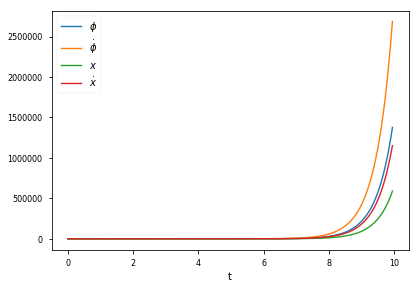

--------------------------------------------------------------------


In [224]:
full_research(shift_system_simple,shiftvars,nocontrol,[("M",3),("m",0.5),("l",3)],[[0.01,0,0,0]], 10, 0.05)

Система не обладает необходимым устойчивым с.р. без управления.
Подбор стратегии управления будем осуществлять тем же способом, что и для первого варианта маятника.
Условие $u(0,0) = 0$ сохраняется и для этой системы. По этой причине можно попробовать использовать те же стратегии управления.

## 2.4 Выбор управления для стабилизации маятника в вертикальном состоянии (упрощ. система)
Находя характеристическое уравнение системы с простым линейным управлением получаем: $\lambda^2(\lambda^2 - \frac{g(M+m) +am}{Ml}) = 0$ Таким образом единственный вариант стабилизации который возможен таким образом - колебания с малой амплитудой, т.е. при условии, что $a< -\frac{g(M+m)}{m}$. Для данных параметров $a < -68.67$. Проверим полученный результат, исследовав замкнутую систему:

Управление верно: True
--------------------------------------------------------------------
Состояния равновесия:
Устойчивое(гарм. колебания)  в  (0.0, 0.0, x0, 0.0)
--------------------------------------------------------------------
Осцилограммы и соответствующие анимации:


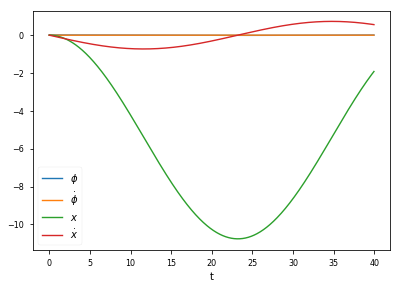

--------------------------------------------------------------------


In [228]:
full_research(shift_system_simple,shiftvars,linear_control,[("M",3),("m",0.5),("l",3),("a",-69)],[[0.01,0,0,0]], 40, 0.05)

Управление верно: False
--------------------------------------------------------------------
Состояния равновесия:
Неустойчивое  в  (0.0, 0.0, x0, 0.0)
--------------------------------------------------------------------
Осцилограммы и соответствующие анимации:


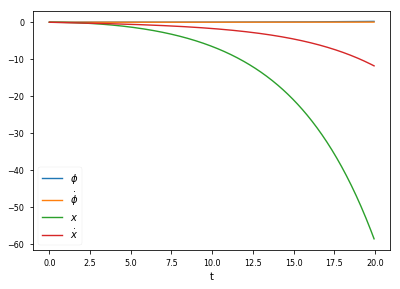

--------------------------------------------------------------------


In [229]:
full_research(shift_system_simple,shiftvars,linear_control,[("M",3),("m",0.5),("l",3),("a",-68)],[[0.01,0,0,0]], 20, 0.05)

Полученный результат иллюстрирует важность выбора a. При значении чуть меньше необходимого смещение опоры не успевает за падением маятника. По тем же причинам что и ранее, в другой модели, осцилляторное управление работает аналогично и имеет ту же допустимую область параметра a. Исследование этого ниже:

Управление верно: True
--------------------------------------------------------------------
Состояния равновесия:
Устойчивое(гарм. колебания)  в  (0, 0, x0, 0)
--------------------------------------------------------------------
Осцилограммы и соответствующие анимации:


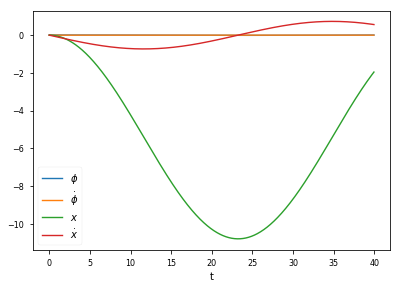

--------------------------------------------------------------------


In [230]:
full_research(shift_system_simple,shiftvars,oscill_control,[("M",3),("m",0.5),("l",3),("a",-69)],[[0.01,0,0,0]], 40, 0.05)

Управление верно: False
--------------------------------------------------------------------
Состояния равновесия:
Неустойчивое  в  (0, 0, x0, 0)
--------------------------------------------------------------------
Осцилограммы и соответствующие анимации:


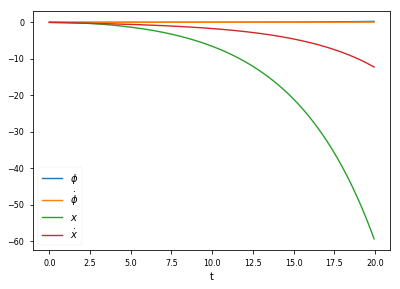

--------------------------------------------------------------------


In [231]:
full_research(shift_system_simple,shiftvars,oscill_control,[("M",3),("m",0.5),("l",3),("a",-68)],[[0.01,0,0,0]], 20, 0.05)

## 2.5 Исследование исходной модели без управления

Управление верно: False
--------------------------------------------------------------------
Состояния равновесия:
Неустойчивое  в  (0.0, 0.0, x0, 0.0)
Устойчивое(гарм. колебания)  в  (3.14159265358979, 0.0, x0, 0.0)
--------------------------------------------------------------------
Осцилограммы и соответствующие анимации:


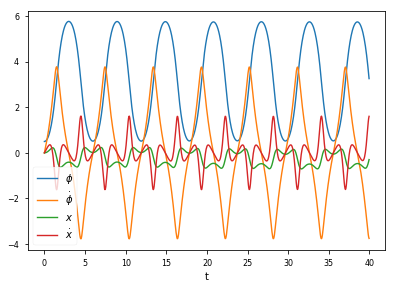

--------------------------------------------------------------------


In [232]:
full_research(shift_system,shiftvars,nocontrol,[("M",3),("m",0.5),("l",3)],[[0.5,0,0,0]], 40, 0.05)

Результат полностью соответствует ожидаемому: гармонические колебания с неизменной амплитудой, зависящей от начальных условий. 

## 2.6 Проверка применимости управления, использованного для упрощеной модели, для исходной модели.

Управление верно: True
--------------------------------------------------------------------
Состояния равновесия:
Устойчивое(гарм. колебания)  в  (0, 0, x0, 0)
--------------------------------------------------------------------
Осцилограммы и соответствующие анимации:


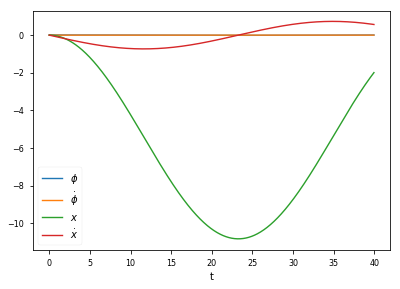

--------------------------------------------------------------------


In [233]:
full_research(shift_system,shiftvars,linear_control,[("M",3),("m",0.5),("l",3),("a",-69)],[[0.01,0,0,0]], 40, 0.05)

Управление верно: True
--------------------------------------------------------------------
Состояния равновесия:
Устойчивое(гарм. колебания)  в  (0.0, 0.0, x0, 0.0)
--------------------------------------------------------------------
Осцилограммы и соответствующие анимации:


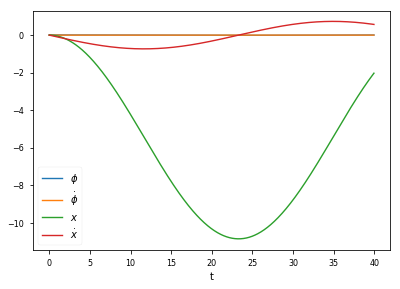

--------------------------------------------------------------------


In [234]:
full_research(shift_system,shiftvars,oscill_control,[("M",3),("m",0.5),("l",3),("a",-69)],[[0.01,0,0,0]], 40, 0.05)

Оба полученных из упрощённой системы управления так же работают и для более сложной, исходной системы.
Но что произойдёт если начальный угол или скорость были слишком велики?

Управление верно: True
--------------------------------------------------------------------
Состояния равновесия:
Устойчивое(гарм. колебания)  в  (0, 0, x0, 0)
--------------------------------------------------------------------
Осцилограммы и соответствующие анимации:


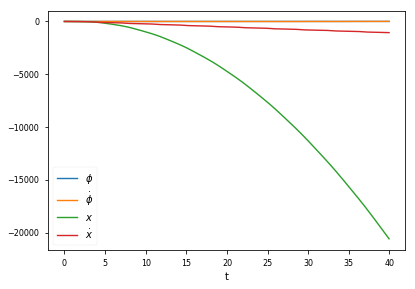

--------------------------------------------------------------------


In [235]:
full_research(shift_system,shiftvars,linear_control,[("M",3),("m",0.5),("l",3),("a",-69)],[[0.5,0,0,0]], 40, 0.05)

Управление верно: True
--------------------------------------------------------------------
Состояния равновесия:
Устойчивое(гарм. колебания)  в  (0, 0, x0, 0)
--------------------------------------------------------------------
Осцилограммы и соответствующие анимации:


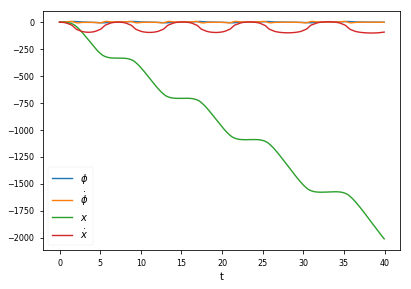

--------------------------------------------------------------------


In [236]:
full_research(shift_system,shiftvars,linear_control,[("M",3),("m",0.5),("l",3),("a",-69)],[[0.01,2,0,0]], 40, 0.05)

Управление не сработало, однако полученный результат корректен, поскольку для возможной стабилизации рассматривается малая окрестность состояния равновесия, а упрощённая система как раз его и описывает. То есть стабилизация маятника при больших начальных углах или скоростях таким способом попросту невозможна.

# 3. Дополнительные вопросы
## 3.1 Стабилизация смещением из положения снизу

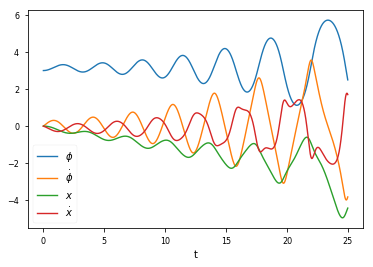

In [139]:
def param_pendulum(l,M,m,u):
    def pendulum(t, x: np.array):
        return np.array([
            x[1],
            ((9.81*(M + m)-m*l*(x[1]*x[1])*np.cos(x[0]))*np.sin(x[0])+u(x)*m*np.cos(x[0]))
            /(M + m*np.sin(x[0])*np.sin(x[0]))/l,
            x[3],
            ((9.81*np.cos(x[0]) - l*x[1]*x[1])*np.sin(x[0]) + u(x))/(np.sin(x[0])*np.sin(x[0]) + M/m)
        ])
    return pendulum

# Управление, этап 1. Увеличиваем амплитуду колебаний угла, чтобы поднять маятник наверх
def param_control_stage1(a):
    def control(x:np.array):
        return a*x[1]
    return control

my_control = param_control_stage1(-5)
pendulum_system = param_pendulum(3,3,0.5,my_control)

vid,data1 = int_curve(pendulum_system,[3,0,0,0],25,0.01)
display(HTML(vid))

[5.545039315891672, 0.8952175041198012, -2.266688823003316, -1.4932592953414208]


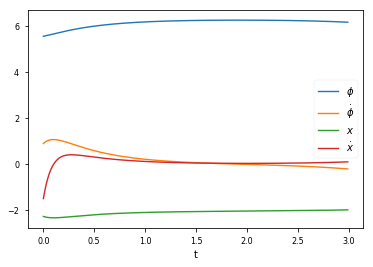

In [138]:
# Управление, этап 2. После достижения нужного угла (pi/2) этапом 1 
def param_control_stage2(a):
    def control(x:np.array):
        return a*(np.sin(x[0]) + x[3])
    return control

my_control = param_control_stage2(-80)
pendulum_system = param_pendulum(3,3,0.5,my_control)

for i1 in range(len(data1[0])):
    if(np.cos(data1[0][i1]) > 1/np.sqrt(2)):
        break
begin1 = [data1[0][i1],data1[1][i1],data1[2][i1],data1[3][i1]]

print(begin1)
vid,data2 = int_curve(pendulum_system,begin1,3,0.01)
display(HTML(vid))

[6.244375054226396, 0.009296419363179325, -2.039829117532088, 0.03538550209605571]


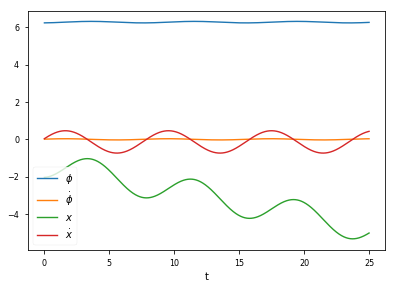

In [237]:
def param_control_stage3(a):
    def control(x:np.array):
        return a*np.sin(x[0])
    return control

my_control = param_control_stage3(-80)
pendulum_system = param_pendulum(3,3,0.5,my_control)


for i2 in range(len(data2[0])):
    if(abs(data2[1][i2])<0.01):
        break
begin2 = [data2[0][i2],data2[1][i2],data2[2][i2],data2[3][i2]]

print(begin2)
vid,_ = int_curve(pendulum_system,begin2,25,0.01)
display(HTML(vid))

## 3.2 Стабилизация вращением с учётом направления скорости

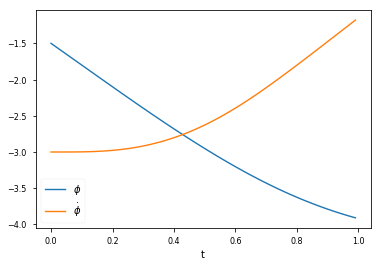

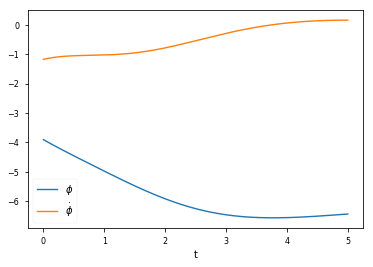

In [209]:
def param_pendulum_spin(l,k,u):
    def pendulum_spin(t, x: np.array):
        return np.array([
            x[1],
            -2*k*x[1] + l*np.sin(x[0])/9.81 + u(x)
        ])
    return pendulum_spin

# Управление, этап 1. 
def spin_control(a):
    def spin_control(x:np.array):
        return -a*np.sin(x[0])
    return spin_control

my_control_1 = spin_control(-2)
my_control_2 = spin_control(2)
pendulum_system_1 = param_pendulum_spin(9.81,0.5,my_control)
pendulum_system_2 = param_pendulum_spin(9.81,0.5,my_control_2)
vid,data1 = int_curve(pendulum_system_1,[-1.5,-3],1,0.01)
display(HTML(vid))


begin1 = [data1[0][-1],data1[1][-1]]
vid,_ =  int_curve(pendulum_system_2,begin1,5,0.01)
display(HTML(vid))